In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(0)

In [3]:
tf = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Import data
train = datasets.get_coco(transform=tf)
test = datasets.get_coco(transform=tf, train=False)

reshape = nn.AvgPool2d(4)

# Get data parameters
N = len(train)
M = 384 * 384
Q = 96 * 96


# Set training parameters and loader
batch_size = 32
epochs = 8
nu = 0.0005
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'pie_dense_superres_patch_var'

In [4]:
class VPIESuperresolution(nn.Module):
    
    def __init__(
        self, 
        entry_patch_dims, 
        entry_grid_dims,
        patch_dims_A, 
        grid_dims_A, 
        patch_dims_B, 
        grid_dims_B, 
        splitters,
        old_net=None,
        **kwargs
    ):
        super().__init__()
        dct_entry = OrderedDict({
            'S1': splitters[0],
            'X': models.dense.AdjointDenseMixer(
                entry_patch_dims, 
                entry_grid_dims, 
                **kwargs
            ),
        })
        self.split_dim = grid_dims_A[0]    
        self.splitter_Y = splitters[1]
        self.splitter_Z = splitters[2]
        
        
        self.X = modules.AdjointSequential(dct_entry)

        self.YZ = models.dense.AdjointConcurrentMixer(
            patch_dims_A,
            grid_dims_A,
            patch_dims_B,
            grid_dims_B,
            stochastic=True,
            **kwargs
        )

    def forward(self, input, *args, sample=True, **kwargs):
        e = self.X(input)
        a = e[...,:self.split_dim]
        b = e[...,self.split_dim:]
        y, z, mu, lv = self.YZ(a, b, sample=sample)
        y = self.splitter_Y(y)
        mu = self.splitter_Z(mu)
        lv = self.splitter_Z(lv)
        z = self.splitter_Z(z)
        return y, z, mu, lv
    
    def T(self, y, z, *args, **kwargs):
        z = self.splitter_Z.T(z)
        y = self.splitter_Y.T(y)
        a, b = self.YZ.T(y, z)
        e = torch.cat([a, b], dim=-1)
        return self.X.T(e)
                

In [5]:
def get_old_net():
    experiment_name = 'pie_dense_superres_patch'
    serialized_path = f'../serialized/experiments/{experiment_name}/'
    nets = {'PIE': None,}
    for m in nets:
        with open(f'{serialized_path}{m}.pt', 'rb') as outfile:
            nets[m] = torch.load(outfile)
    return nets['PIE']


In [6]:
#entry_patch_dims = [256, 256, 256, 256, 256]
#entry_grid_dims =  [576, 484, 361, 196,  36]

# entry_patch_dims = [256, 256, 256, 256, 256]
# entry_grid_dims =  [576, 576, 576, 576, 576]

entry_patch_dims = [256, 1024, 256]
entry_grid_dims =  [576,  144, 576]

patch_dims_A = [256, 256, 256]
grid_dims_A =  [ 36,  36,  36]

patch_dims_B = [256, 1280, 256]
grid_dims_B =  [540,  108, 540]

old_net = get_old_net().to(device)

split1 = modules.AdjointSequential(
    modules.AdjointPatchSplitter((24,24), (16,16)),
    modules.AdjointFlatten(-2, -1, (24,24))
)

split2 = modules.AdjointSequential(
    modules.AdjointUnflatten(-2, -1, (6, 6)),
    modules.AdjointPatchUnsplitter((6,6), (16,16)),
)

flat = modules.AdjointFlatten(-2, -1, (256, 540))

splitsmall = modules.AdjointSequential(
    modules.AdjointPatchSplitter((24,24), (4,4)),
    modules.AdjointFlatten(-2, -1, (24,24))
)

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device,
}

nets = {
    "PIE": VPIESuperresolution(
        entry_patch_dims,
        entry_grid_dims,
        patch_dims_A,
        grid_dims_A,
        patch_dims_B,
        grid_dims_B,
        (split1, split2, flat),
        old_net = None,
        diagonal = True,
        init=nn.init.orthogonal_,
        **model_kwargs,
    ),
}

import gc
del old_net
gc.collect();

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)

In [7]:
# Define objective function

def objective_function(x, xh, y, yh, mu, lv, params=None, alpha=16.0, l2_lambda=1e-6, beta=24.0, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = utils.loss.logcosh(xh, x, alpha=alpha, reduction=reduction)    
    losses['ly'] = utils.loss.logcosh(yh, y, alpha=alpha, reduction=reduction)
    losses['kl'] = beta * utils.loss.kl_divergence(mu, lv, reduction=reduction, total_size=len(train))
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [8]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params PIE     :  3214272


In [9]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k] for k in sample_indices_small])
ys = reshape(xims).to(device)
xs = xims.to(device)

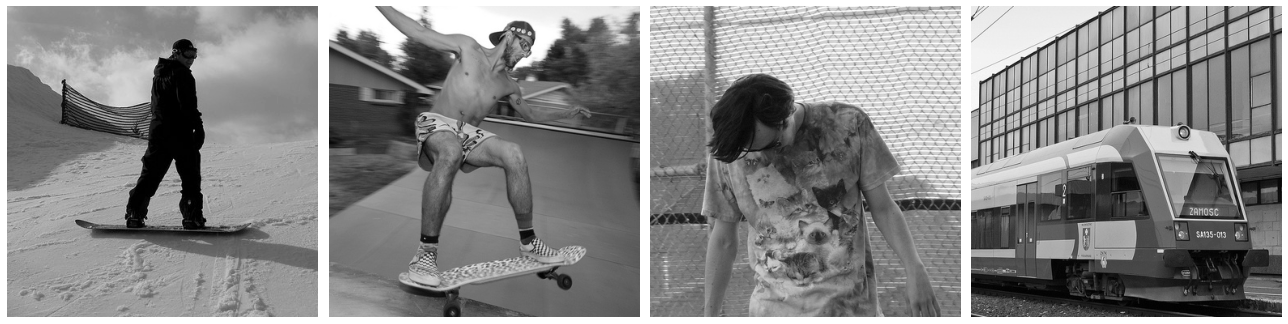

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(xims[i], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

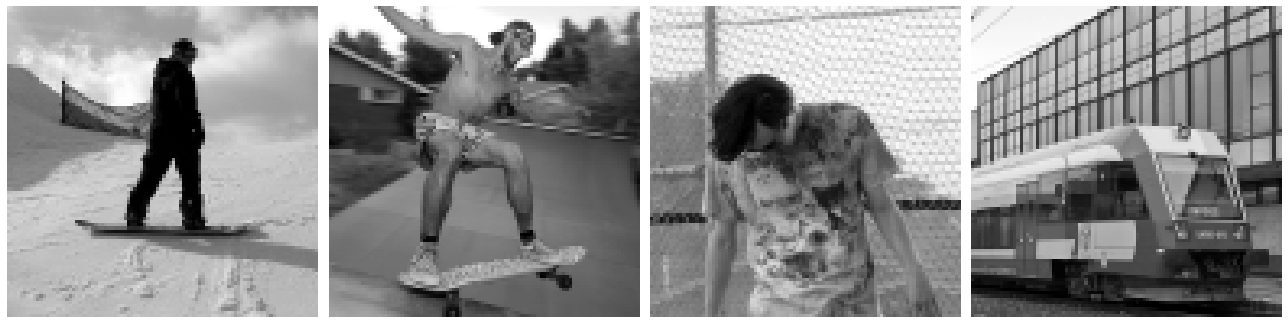

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(reshape(xims[i][None,...])[0], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

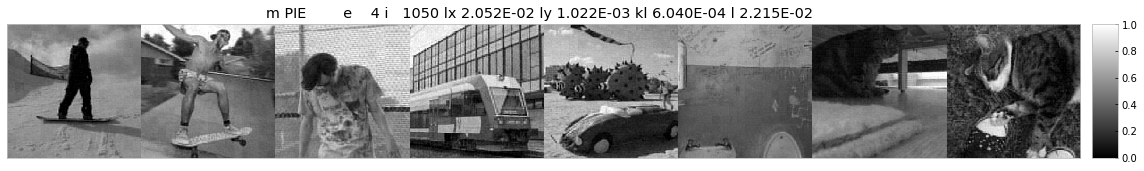

In [ ]:
# Training loop

for e in range(epochs):
    i = 0
    for x in loader:
        y = reshape(x.to(device)).detach()
        x = x.to(device)
                
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()            
            yh, z, mu, lv = nets[cur](x)
            xh = nets[cur].T(y, z)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh, mu, lv)

            loss.backward()
            opts[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 25 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    yh, z, _, _ = nets[cur](xs, sample=True)
                    xhs[cur] = nets[cur].T(ys, z).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name, save=(i % 50 == 0), cmap='gray')
            
        i += 1

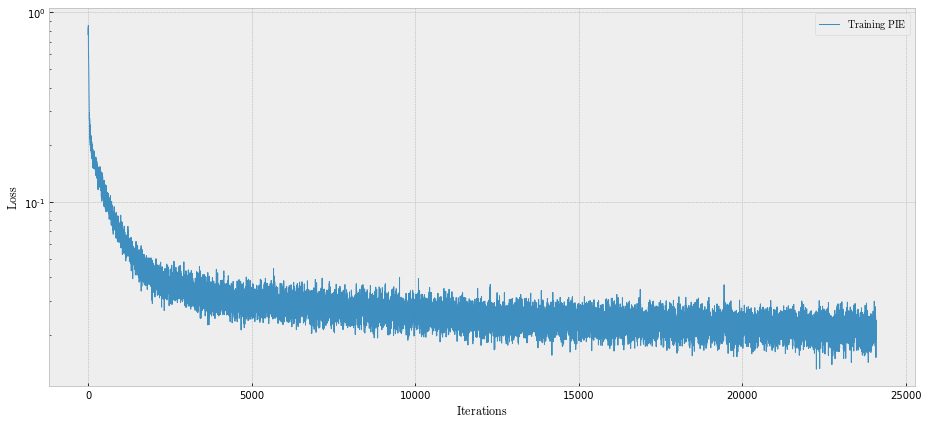

In [14]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["l"], linewidth=1, label=f"$\mathrm{{Training\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
#plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

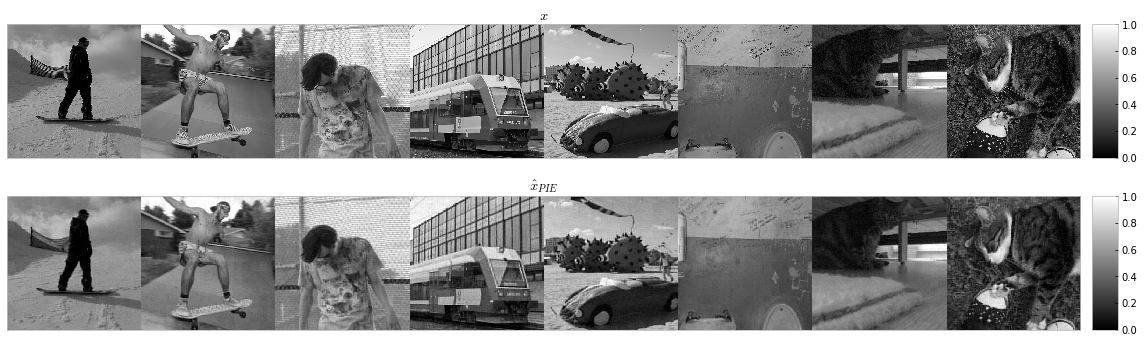

In [20]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        yh, z, _, _ = nets[cur](xs, sample=True)
        xhs[k] = nets[cur].T(ys, z).cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

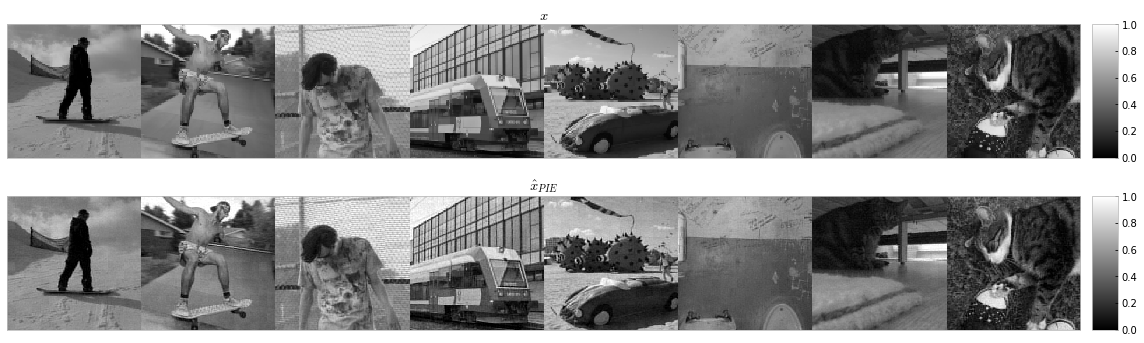

In [50]:
# Plot results
with torch.no_grad():
    xhs = {"": ys.cpu()}
    
    for k in nets.keys():
        yh, z, _, _ = nets[cur](xs)
        xhs[k] = nets[cur].T(yh, z).cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name + '_through', cmap='gray')

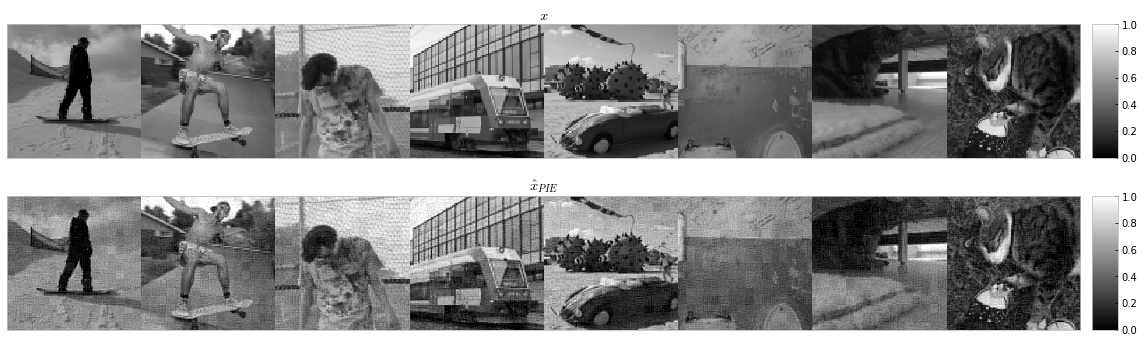

In [73]:
# Plot results
with torch.no_grad():
    xhs = {"": ys.cpu()}
    
    for k in nets.keys():
        yh, z, _, _ = nets[cur](xs)
        z = torch.randn_like(z)
        xhs[k] = nets[cur].T(ys, z).cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

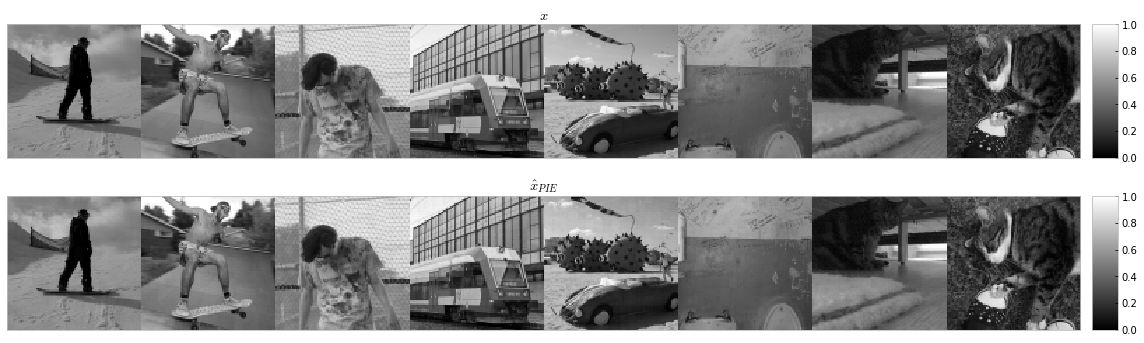

In [23]:
# Plot results
with torch.no_grad():
    xhs = {"": ys.cpu()}
    
    for k in nets.keys():
        yh, z, _, _ = nets[cur](xs)
        z = torch.randn_like(z)
        xhs[k] = yh.cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name + '_ys', cmap='gray')

In [9]:
example = 6888

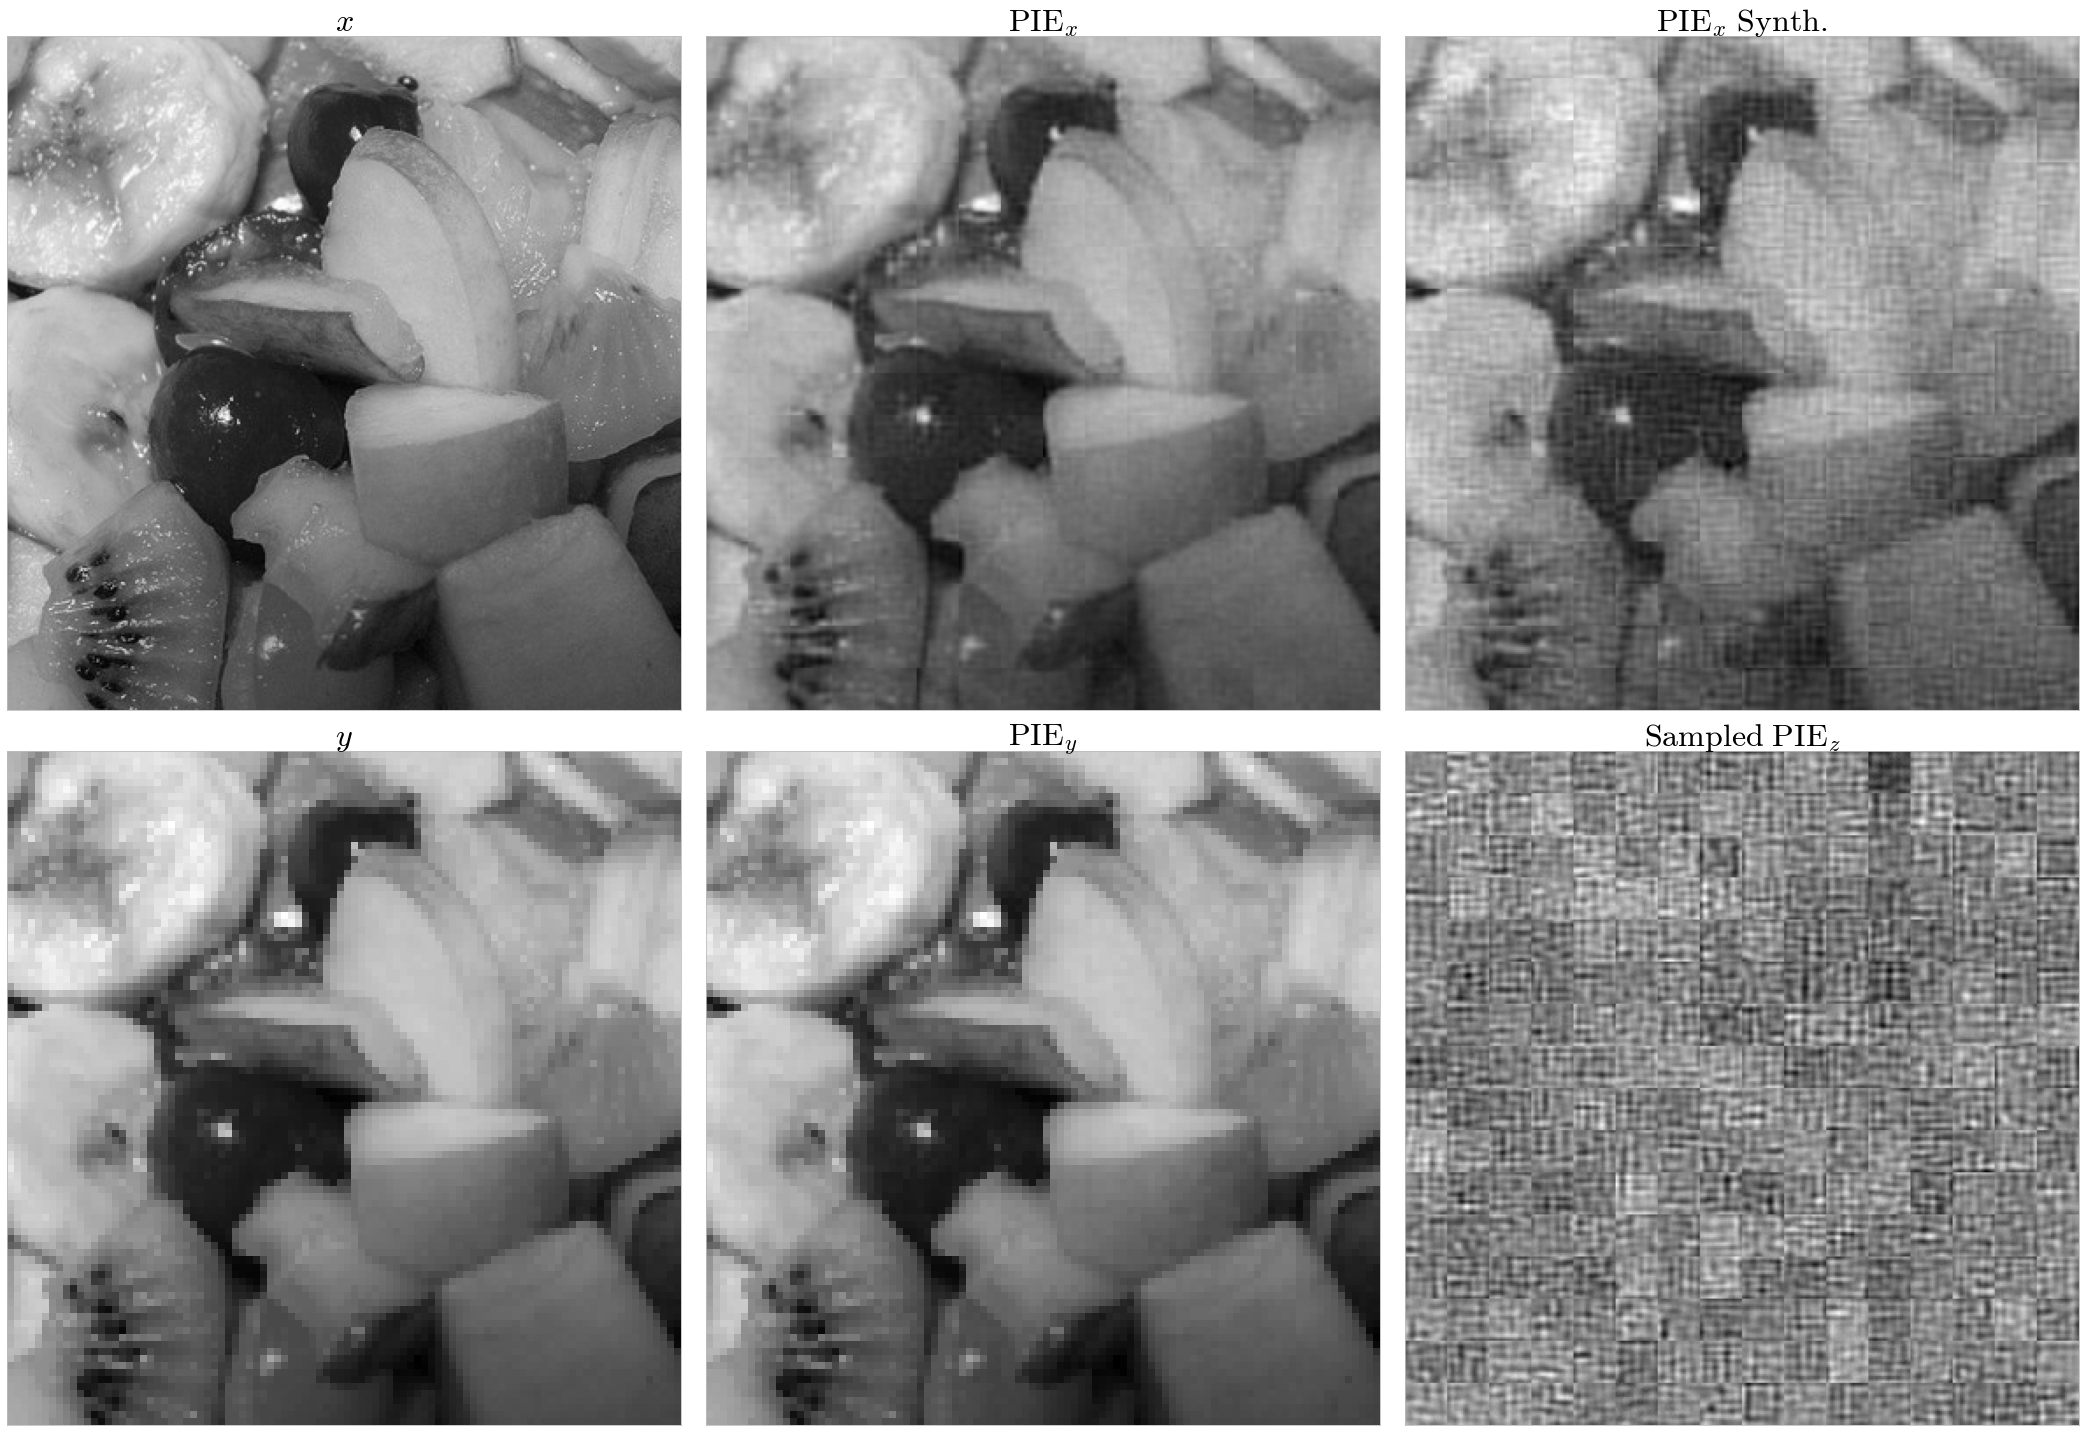

In [32]:
for cur in nets:
    nets[cur].to(device)

fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh, z, _, _ = nets[cur](train[example].to(device))
        xh = nets[cur].T(reshape(train[example]).to(device), z)
        z = torch.randn_like(z)
        xhz = nets[cur].T(reshape(train[example]).to(device), z)
        yhz = torch.ones_like(yh) * 0.5
        xhzz = nets[cur].T(yhz, z)

    ax[0,i+1].imshow(
        xh.cpu()[0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)

    ax[0,i+2].imshow(
        xhz.cpu()[0],
        cmap='gray'
    )
    ax[0,i+2].set_title(f'$\mathrm{{{cur}}}_x \,\,\mathrm{{Synth.}}$', fontsize=32)
    
    ax[1,i+1].imshow(
        yh.cpu()[0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
    ax[1,i+2].imshow(
        xhzz.cpu()[0],
        cmap='gray'
    )
    ax[1,i+2].set_title(f'$\mathrm{{Sampled\,\,{cur}}}_z$', fontsize=32)
    
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit.pdf')

In [33]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [34]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [35]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [12]:
# Load models
if 'nets' not in globals() or 'PIE' not in nets:
    nets = {'PIE': None}

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

Final loss: 0.8571487665176392


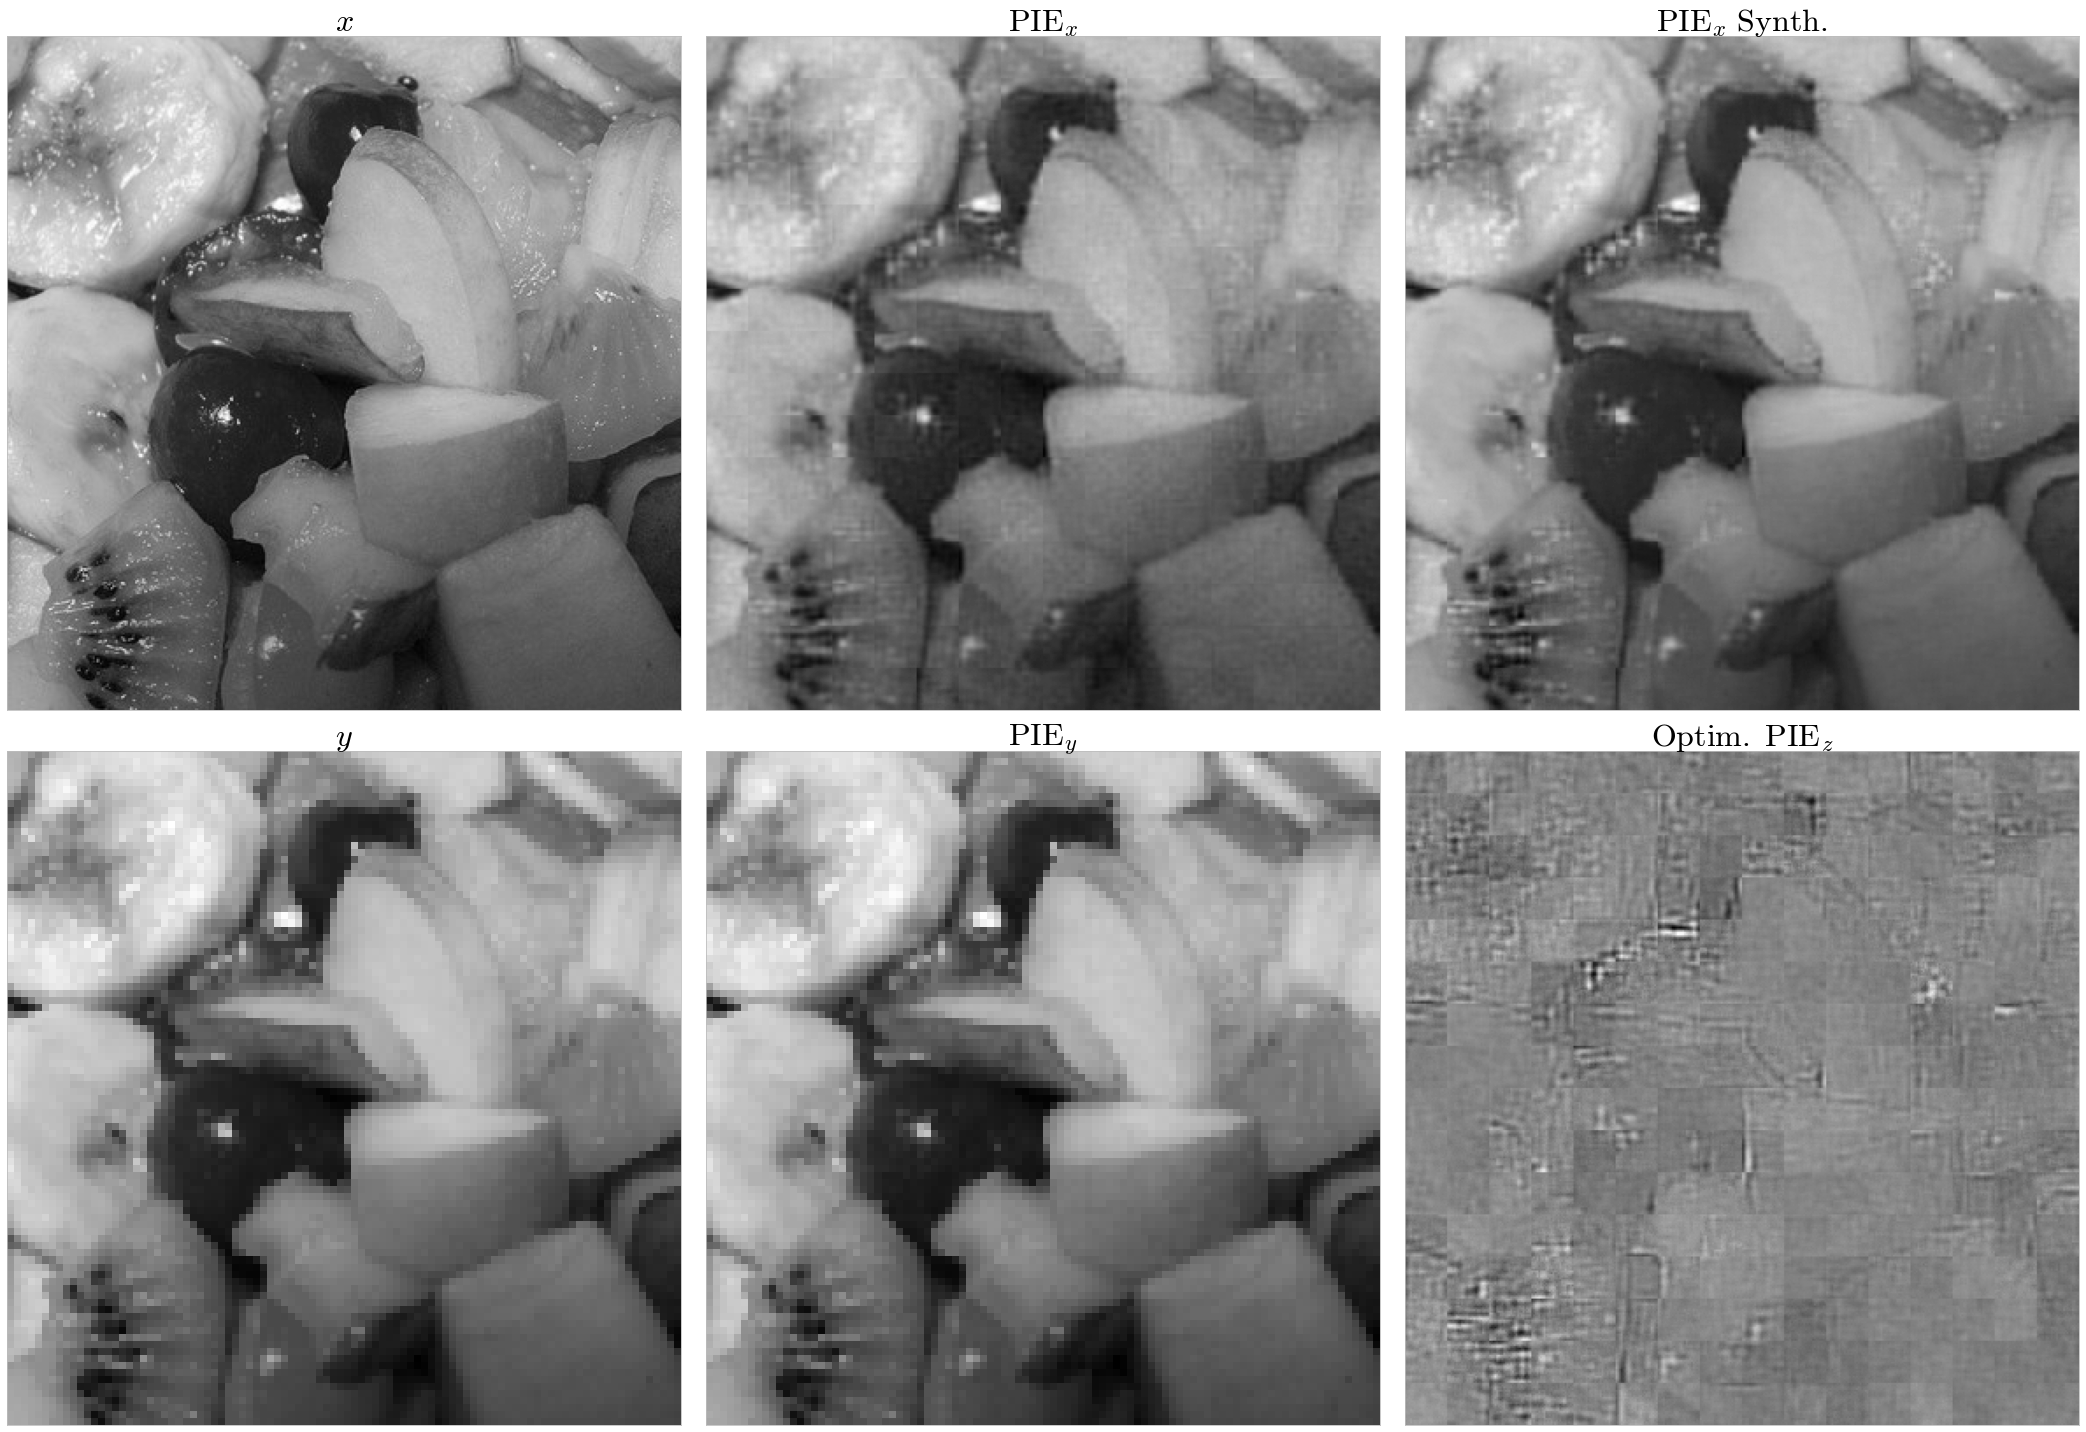

In [35]:
for cur in nets:
    nets[cur].to(device)

fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh, z, _, _ = nets[cur](train[example].to(device))
        xh = nets[cur].T(reshape(train[example]).to(device), z)

    # Perform Gradient Descent to find optimal random vector
    z.requires_grad_(True)
    nets[cur].requires_grad_(False)
    opt_z = torch.optim.Adam([z], lr=1e-3)
    for j in range(10000):
        opt_z.zero_grad()
        xhz = nets[cur].T(reshape(train[example]).to(device), z)
        #loss = utils.loss.logcosh(xhz[:,None,...], train[example][:,None,...].to(device), alpha=16.0) 
        loss = -utils.metrics.ssim(xhz[:,None,...], train[example][:,None,...].to(device))
        loss.backward()
        opt_z.step()
        
        if j % 100 == 0:
            print(f'i:{j:5d} {loss.item():7e}')
            clear_output(wait=True)

    xhz = nets[cur].T(reshape(train[example]).to(device), z).detach()
    yhz = torch.ones_like(yh) * 0.5
    xhzz = nets[cur].T(yhz, z).detach()

    nets[cur].requires_grad_(True)
    
    ax[0,i+1].imshow(
        xh.cpu()[0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)

    ax[0,i+2].imshow(
        xhz.cpu()[0],
        cmap='gray'
    )
    ax[0,i+2].set_title(f'$\mathrm{{{cur}}}_x \,\,\mathrm{{Synth.}}$', fontsize=32)
    
    ax[1,i+1].imshow(
        yh.cpu()[0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
    ax[1,i+2].imshow(
        xhzz.cpu()[0],
        cmap='gray'
    )
    ax[1,i+2].set_title(f'$\mathrm{{Optim. \,\, {cur}}}_z$', fontsize=32)
    nets[cur].requires_grad_(False)
    
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit_optimized.pdf')
print('Final loss:', -loss.item())

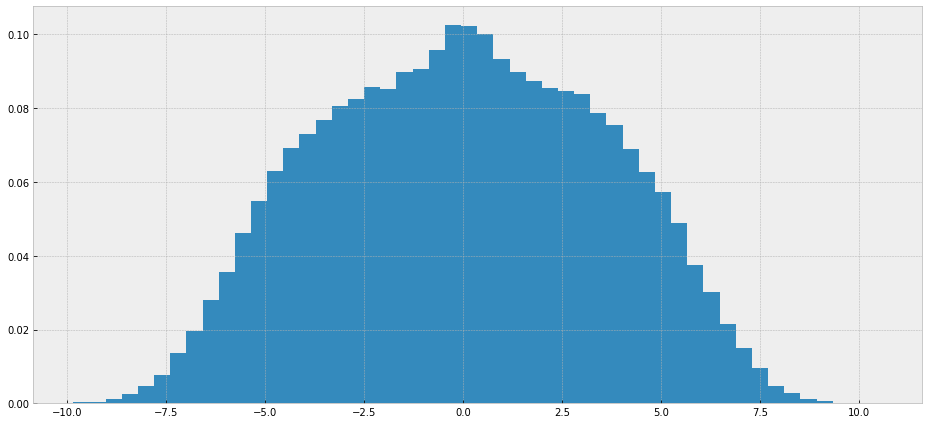

In [47]:
plt.hist(z.detach().cpu().numpy()[0], bins=50, density=True);
plt.savefig(f'../figures/misc/{experiment_name}_fruit_optimized_zhist.pdf')

In [13]:
# Compute test tensor

test_tensor = []
for i in tqdm(range(len(test))):
    test_tensor.append(test[i])
    
test_tensor = torch.cat(test_tensor)

  0%|          | 0/4002 [00:00<?, ?it/s]

In [14]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        yth, z, _, _ = model(test_tensor)
        xth = model.T(reshape(test_tensor), z)
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(xth.flatten(-2,-1), test_tensor.flatten(-2,-1), reduction='mean'):4E} " +
        f"RE {utils.metrics.relative_error(yth.flatten(-2,-1), reshape(test_tensor).flatten(-2,-1), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(xth.flatten(-2,-1), test_tensor.flatten(-2,-1), reduction='mean'):4E} "
        f"MSE {F.mse_loss(yth.flatten(-2,-1), reshape(test_tensor).flatten(-2,-1), reduction='mean'):4E} "
    )

Relative Error:
PIE   : RE 1.254393E-01 RE 2.290686E-02 MSE 4.340030E-03 MSE 1.343911E-04 


In [15]:
(1.254410E-01 + 2.290686E-02) / 2 

0.07417393

In [16]:
import gc

del xth, yth
gc.collect();

In [19]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        yth, z, _, _ = model(test_tensor)
        xth = model.T(reshape(test_tensor), z)
        psnr = utils.metrics.psnr(test_tensor.flatten(-2,-1), xth.flatten(-2,-1))
        ssim = utils.metrics.ssim(
            test_tensor[:,None,...], 
            xth[:,None,...]
        )
        psnry = utils.metrics.psnr(reshape(test_tensor).flatten(-2,-1), yth.flatten(-2,-1))
        ssimy = utils.metrics.ssim(
            reshape(test_tensor)[:,None,...], 
            yth[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

Image Reconstruction Metrics:
PIE   : PSNR 2.362517E+01 SSIM 6.978529E-01 


In [20]:
psnr = utils.metrics.psnr(test_tensor.flatten(-2,-1), xth.flatten(-2,-1))
ssim = utils.metrics.ssim(
    test_tensor[:,None,...], 
    xth[:,None,...]
)
psnry = utils.metrics.psnr(reshape(test_tensor).flatten(-2,-1), yth.flatten(-2,-1))
ssimy = utils.metrics.ssim(
    reshape(test_tensor)[:,None,...], 
    yth[:,None,...]
)
print(
    f"{k:6}: " + 
    f"PSNR {psnr:4E} " +
    f"SSIM {ssim:4E} " +
    f"PSNR {psnry:4E} " +
    f"SSIM {ssimy:4E} "
)


PIE   : PSNR 2.362517E+01 SSIM 6.978529E-01 PSNR 3.871629E+01 SSIM 9.850240E-01 


In [21]:
(2.362498E+01 + 3.871629E+01)/2

31.170635

In [22]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(384, 384).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [23]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

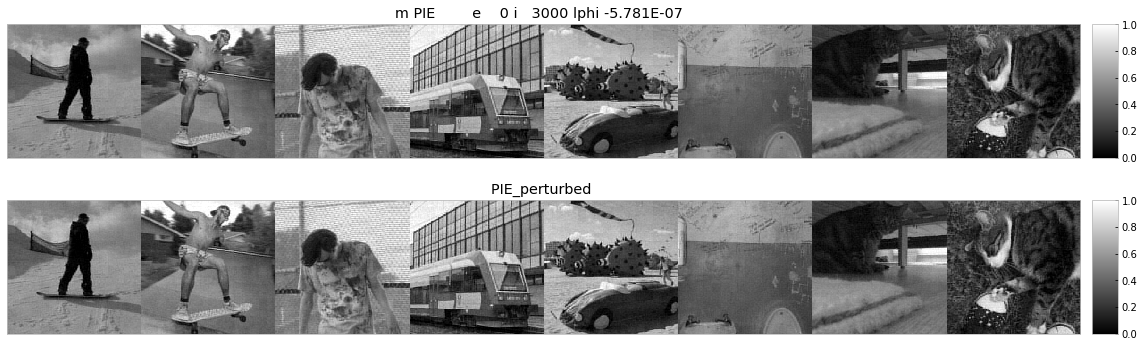

In [24]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = reshape(x.to(device)).detach()
        x = x.to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (384, 384))

            xh = nets[cur].T(*nets[cur](x, sample=False)[:2])
            xe = nets[cur].T(*nets[cur](x + r, sample=False)[:2])

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(*nets[cur](xs)[:2]).cpu()
                    xhs[per] = nets[cur].T(*nets[cur](xs + r)[:2]).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [25]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].cpu().flatten(-2, -1), 1, 2).unflatten(-1, (384, 384))
        XE = model.T(*model(test_tensor + r, sample=False)[:2])

    print(f"{k:6}: {utils.metrics.relative_error(test_tensor + r.cpu(), XE, reduction='mean')}")

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].cpu().flatten(-2, -1), 1, 2).unflatten(-1, (384, 384))
        XE = model.T(*model(test_tensor + r, sample=False)[:2])
        XH = model.T(*model(test_tensor, sample=False)[:2])

    rerr_psi = utils.metrics.relative_error(XH.flatten(-2,-1), XE.flatten(-2,-1), reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor.flatten(-2,-1), test_tensor.flatten(-2,-1) + r.flatten(-2,-1), reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), test_tensor.flatten(-2,-1), r.flatten(-2,-1), reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
PIE   : 0.13569217920303345
Relative Cond:
PIE   : 0.001573 0.005357 0.052084


In [26]:
rerr_x = utils.metrics.relative_error(test_tensor.flatten(-2,-1), test_tensor.flatten(-2,-1) + r.flatten(-2,-1), reduction='mean')
cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), test_tensor.flatten(-2,-1), r.flatten(-2,-1), reduction='mean')
print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

PIE   : 0.001573 0.005357 0.052084


In [79]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

for k, model in nets.items():
    with torch.no_grad():
        _, _, mu, lv = model(test_tensor)
        print(f'KL: {utils.loss.kl_divergence(mu, lv, "mean", len(test))}')

KL: 0.10391947627067566


In [19]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(384, 384).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [20]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

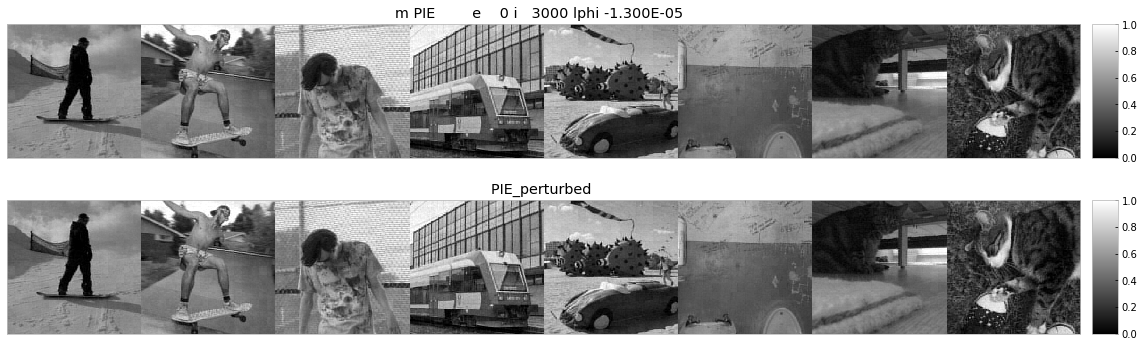

In [25]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = reshape(x.to(device)).detach()
        x = x.to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2)
            ry = r[:96**2].unflatten(-1, (96, 96))
            rz = r[96**2:]
            
            y, z, mu, lv = nets[cur](x, sample=False)

            xh = nets[cur].T(y, z)
            xe = nets[cur].T(y + ry, z + rz)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2)
                    ry = r[:96**2].unflatten(-1, (96, 96))
                    rz = r[96**2:]

                    y, z, mu, lv = nets[cur](xs, sample=False)

                    xhs[cur] = nets[cur].T(y, z).cpu()
                    xhs[per] = nets[cur].T(y + ry, z + rz).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [30]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")
for k, model in nets.items():
    with torch.no_grad():        
        r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).cpu()
        ry = r[:96**2].unflatten(-1, (96, 96))
        rz = r[96**2:]
        y, z, mu, lv = nets[cur](test_tensor, sample=False)
        XH = nets[cur].T(y, z)
        XE = nets[cur].T(y + ry, z + rz)

    cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), test_tensor.flatten(-2,-1), r, reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
PIE   : 0.247169
